In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


In [2]:
import pandas as pd
import seaborn as sns
from glob import glob
import PIL
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

# turn off gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from scipy.stats import ttest_ind_from_stats as ttest
from source.project_manager import load_experiment_metadata
from source.data_manager import preprocess, save_axis

# run this without ? to comput aucs for an experiment
# run this with ? to merge
# run this with ? twice to merge aucs accross experiments
save_metadata_dir = "outputs/metadata/7_?_*/"


imshow_args = {"cmap": "jet"}

2024-03-12 10:40:35.455858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 10:40:35.455929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 10:40:35.457874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 10:40:35.494463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 10:40:38.531447: W tensorflow/compiler/tf2

In [3]:
path_to_acc_data = "outputs/processed/7/7_acc_data.csv"
index_cols = [
    "alpha_mask_value",
    "q_direction",
    "q_baseline_mask",
    "combination",
    "projection_type",
    "batch",
]
static_data_acc = pd.read_csv(
    "outputs/processed/7/7_static_acc_data.csv",
    index_col=index_cols,
)
static_data_acc.columns = static_data_acc.columns.astype(int)


def fill_na():
    alphas = merged_data_acc.index.get_level_values("alpha_mask_value").unique()
    for alpha in alphas:
        q_directions = (
            merged_data_acc.loc[alpha].index.get_level_values("q_direction").unique()
        )
        for q_direction in q_directions:
            q_baseline_masks = (
                merged_data_acc.loc[alpha, q_direction]
                .index.get_level_values("q_baseline_mask")
                .unique()
            )
            for q_baseline_mask in q_baseline_masks:
                combinations = (
                    merged_data_acc.loc[alpha, q_direction, q_baseline_mask]
                    .index.get_level_values("combination")
                    .unique()
                )
                for combination in combinations:
                    # select the key that is computed for 0 and 100
                    temp = static_data_acc.loc[
                        ("ig_vg_u_x_0", "deletion", q_baseline_mask, "additive"),
                        [0, 100],
                    ]

                    # check if there are any nan values in the selected key
                    assert (
                        temp.isna().sum().sum() == 0
                    ), f"alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"

                    # check if the index of the selected key is the same as the index of the merged_data_acc
                    index2 = temp.index
                    index1 = merged_data_acc.loc[
                        (alpha, q_direction, q_baseline_mask, combination), [0, 100]
                    ].index
                    assert (
                        index1.shape == index2.shape
                    ), f"shape mismatch {index1.shape}!={index2.shape} at alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"
                    assert (
                        index1 != index2
                    ).sum() == 0, f"alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"

                    # if the q_direction is insertion, we need to swap the columns
                    if q_direction == "insertion":
                        temp = temp.rename(columns={0: 100, 100: 0})
                        temp = temp[[0, 100]]

                    # replace the values in the merged_data_acc with the selected key
                    merged_data_acc.loc[
                        (alpha, q_direction, q_baseline_mask, combination), [0, 100]
                    ] = temp.values

    merged_data_acc.to_csv(path_to_acc_data)


if os.path.exists(path_to_acc_data):
    merged_data_acc = pd.read_csv(
        path_to_acc_data,
        index_col=index_cols,
    ).sort_index()
    merged_data_acc.columns = merged_data_acc.columns.astype(int)
    if 0 not in merged_data_acc.columns:
        merged_data_acc[0] = np.nan
    if 100 not in merged_data_acc.columns:
        merged_data_acc[100] = np.nan
    merged_data_acc = merged_data_acc.sort_index(axis=1)
    print("loaded acc data previously computed")
    num_na = merged_data_acc.isna().sum().sum()
    if num_na > 0:
        fill_na()
        print("filled na in the acc data")
    else:
        print("number of nan in acc data:", num_na)
elif "?" not in save_metadata_dir:
    paths = os.path.join(save_metadata_dir, "merged_igq_metadata.csv")
    paths = glob(paths)
    print(paths)
    merged_data = []
    for path in paths:
        slq_csv = pd.read_csv(path)
        batch = path.split("/")[-2].split("_")[-1]
        slq_csv["batch"] = batch

        if "additive" in path:
            slq_csv["combination"] = "additive"
        elif "convex" in path:
            slq_csv["combination"] = "convex"
        elif "damping" in path:
            slq_csv["combination"] = "damping"
        else:
            slq_csv["combination"] = None

        merged_data.append(slq_csv)
    merged_data = pd.concat(merged_data, axis=0)

    merged_data_acc = merged_data.pivot_table(
        index=index_cols,
        columns="q",
        values="preds",
        aggfunc="mean",
    )
    merged_data_acc.to_csv(path_to_acc_data)
    print("computed acc data you need to run this cell again with ? to merge")
else:
    paths = glob("outputs/processed/7/7_?_acc_data.csv")
    merged_data_acc = []
    for path in paths:
        merged_data_acc.append(
            pd.read_csv(
                path,
                index_col=index_cols,
            ).sort_index()
        )
    print("concatenating acc data from different runs")
    merged_data_acc = pd.concat(merged_data_acc, axis=0)
    merged_data_acc.to_csv(path_to_acc_data)
    print("saved merged acc data please rerun this cell to fill na")

loaded acc data previously computed
number of nan in acc data: 0


In [6]:
def auc(x):
    return np.trapz(y=x.values, x=[int(x) / 100 for x in x.index])


nice_names = {
    "ig_sg_i_u_x2_0_0.2": "XSL$^2(0,0.2)$",  # & $\operatorname{Unif}(0,0.2)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x2_0_0.4": "XSL$^2(0,0.4)$",  # & $\operatorname{Unif}(0,0.4)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x2_0_0.5": "XSL$^2(0,0.5)$",  # & $\operatorname{Unif}(0,0.6)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x2_0_0.8": "XSL$^2(0,0.8)$",  # & $\operatorname{Unif}(0,0.8)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x2_0_1.0": "XSL$^2(0,1.0)$",  # & $\operatorname{Unif}(0,1.0)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x_0_0.2": "XSL(0,0.2)",  # & $\operatorname{Unif}(0,0.2)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x_0_0.4": "XSL(0,0.4)",  # & $\operatorname{Unif}(0,0.4)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x_0_0.5": "XSL(0,0.5)",  # & $\operatorname{Unif}(0,0.6)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x_0_0.8": "XSL(0,0.8)",  # & $\operatorname{Unif}(0,0.8)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_i_u_x_0_1.0": "XSL(0,1.0)",  # & $\operatorname{Unif}(0,1.0)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x2_0_0.1": "SL$^2(0,0.1)$",  # & $\operatorname{Unif}(0,0.2)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x2_0_0.2": "SL$^2(0,0.2)$",  # & $\operatorname{Unif}(0,0.4)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x2_0_0.5": "SL$^2(0,0.5)$",  # & $\operatorname{Unif}(0,0.6)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x2_0_0.8": "SL$^2(0,0.8)$",  # & $\operatorname{Unif}(0,0.8)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x2_0_1.0": "SL$^2(0,1.0)$",  # & $\operatorname{Unif}(0,1.0)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x_0_0.1": "SL(0,0.1)",  # & $\operatorname{Unif}(0,0.2)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x_0_0.2": "SL(0,0.2)",  # & $\operatorname{Unif}(0,0.4)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x_0_0.5": "SL(0,0.5)",  # & $\operatorname{Unif}(0,0.6)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x_0_0.8": "SL(0,0.8)",  # & $\operatorname{Unif}(0,0.8)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x_0_1.0": "SL(0,1.0)",  # & $\operatorname{Unif}(0,1.0)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "sl_u_x2_0_0.2": "SLT$^2$(0,0.2)",  # & $\operatorname{Tri}(0,0.2)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "sl_u_x2_0_0.4": "SLT$^2$(0,0.4)",  # & $\operatorname{Tri}(0,0.4)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "sl_u_x2_0_0.5": "SLT$^2$(0,0.5)",  # & $\operatorname{Tri}(0,0.6)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "sl_u_x2_0_0.8": "SLT$^2$(0,0.8)",  # & $\operatorname{Tri}(0,0.8)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "sl_u_x2_0_1.0": "SLT$^2$(0,1.0)",  # & $\operatorname{Tri}(0,1.0)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_sg_u_x2_0.1": "SG$^2$(0.1)",
    "ig_sg_u_x2_0.2": "SG$^2$(0.2)",
    "ig_sg_u_x2_0.5": "SG$^2$(0.5)",
    "ig_sg_u_x2_1.0": "SG$^2$(1.0)",
    "ig_sg_u_x_0.1": "SG(0.1)",
    "ig_sg_u_x_0.2": "SG(0.2)",
    "ig_sg_u_x_0.5": "SG(0.5)",
    "ig_sg_u_x_1.0": "SG(1.0)",
    "ig_vg_u_x_0": "SG(0.0)",  # & $\operatorname{Tri}(0,0.2)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_vg_u_x2_0": "SG$^2$(0.0)",  # & $\operatorname{Tri}(0,0.2)$ & $\mathcal{N}(\bsx,0.3\sigma)$",
    "ig_u_x_0": "IG(0.0)",
    "ig_u_x_0.1": "IG(0.1)",
    "ig_u_x_0.2": "IG(0.2)",
    "ig_u_x_0.5": "IG(0.5)",
    "ig_u_x_1.0": "IG(1.0)",
    "ig_u_x2_0": "IG$^2$(0.0)",
    "ig_u_x2_0.1": "IG$^2$(0.1)",
    "ig_u_x2_0.2": "IG$^2$(0.2)",
    "ig_u_x2_0.5": "IG$^2$(0.5)",
    "ig_u_x2_1.0": "IG$^2$(1.0)",
    "ig_u_x2_0_0.2": "IG$^2$(0,0.2)",
    "ig_u_x2_0_0.5": "IG$^2$(0,0.5)",
    "ig_u_x2_0_1.0": "IG$^2$(0,1.0)",
    "ig_u_x2_i_0_0.2": "XIG$^2$(0,0.2)",
    "ig_u_x2_i_0_0.5": "XIG$^2$(0,0.5)",
    "ig_u_x2_i_0_1.0": "XIG$^2$(0,1.0)",
    "ig_u_x_0_0.2": "IG(0,0.2)",
    "ig_u_x_0_0.5": "IG(0,0.5)",
    "ig_u_x_0_1.0": "IG(0,1.0)",
    "ig_u_x_i_0_0.2": "XIG(0,0.2)",
    "ig_u_x_i_0_0.5": "XIG(0,0.5)",
    "ig_u_x_i_0_1.0": "XIG(0,1.0)",
    "ig_occlusion_u_x_nan": "Occlusion",
    "ig_occlusion_u_x2_nan": "Occlusion$^2$",
    "ig_rise_u_x_0.1": "RISE(0.1)",
    "ig_rise_u_x2_0.1": "RISE(0.2)$^2$",
}

aucs = merged_data_acc.apply(lambda x: auc(x), axis=1)
aucs.name = "AUC"
alphas = aucs.index.get_level_values("alpha_mask_value").unique()
aucs = aucs.reset_index()
aucs = aucs.pivot_table(
    index=["alpha_mask_value"],
    columns=["projection_type", "q_direction", "q_baseline_mask", "combination"],
    values="AUC",
    aggfunc=["mean", "std"],
)
f_ = lambda x: f"{x:.3f}"

In [ ]:
occlusion = aucs.loc[
    "ig_occlusion_u_x_nan", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
occlusion = occlusion.map(f_)
occlusion = occlusion.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
occlusion

In [ ]:
rise = aucs.loc[
    "ig_rise_u_x_0.1", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
rise = rise.map(f_)
rise = rise.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
rise

In [ ]:
xig = aucs.loc[
    "ig_u_x_i_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
xig = xig.map(f_)
xig = xig.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
xig

In [ ]:
xig2 = aucs.loc[
    "ig_u_x2_i_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
xig2 = xig2.map(f_)
xig2 = xig2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
xig2

In [ ]:
ig = aucs.loc[
    "ig_u_x_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
ig = ig.map(f_)
ig = ig.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
ig

In [ ]:
ig2 = aucs.loc[
    "ig_u_x2_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
ig2 = ig2.map(f_)
ig2 = ig2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
ig2

In [ ]:
osg = aucs.loc[
    "ig_sg_u_x2_0.5", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
osg = osg.map(f_)
osg = osg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
osg

In [ ]:
osg = aucs.loc[
    "og_sg_u_x2_nan", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
osg = osg.map(f_)
osg = osg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
osg

In [ ]:
sg = aucs.loc[
    "ig_sg_u_x_nan", (slice(None), "prediction", slice(None), "blur", "additive")
].unstack(level=0)
# make it like mean+-std
sg = sg.map(f_)
sg = sg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
sg

In [ ]:
sg2 = aucs.loc[
    "ig_sg_u_x2_nan", (slice(None), "prediction", slice(None), "blur", "additive")
].unstack(level=0)
# make it like mean+-std
sg2 = sg2.map(f_)
sg2 = sg2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
sg2

In [ ]:
igsg = aucs.loc[
    "ig_sg_u_x2_0_1.0", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
igsg = igsg.map(f_)
igsg = igsg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
igsg

In [7]:
ids = aucs.index
ids1 = [x for x in ids if "_x2_" not in x]
ids2 = [x for x in ids if "_x2_" in x]
temp1 = aucs.loc[ids1,]
for stat in ["mean","std"]:
    temp0 = temp1[(stat,"prediction","deletion")]
    temp1[(stat,"prediction","deletion")] = temp1[(stat,"prediction","insertion")]
    temp1[(stat,"prediction","insertion")] = temp0
temp2 = aucs.loc[ids2,]
temp = pd.concat([temp1, temp2], axis=0)
aucs = temp

In [8]:
# apply ttest to the aucs
def significance_test(data: pd.Series):
    q_direction = data.index.get_level_values("q_direction").unique()
    assert len(q_direction) == 1, "q_direction should be unique"
    q_direction = q_direction[0]
    if q_direction == "insertion":
        target_fn = np.argmax
    else:
        target_fn = np.argmin
    data = data.droplevel("q_direction")
    data = data.unstack(level=0)
    target_id = target_fn(data["mean"])
    target_mean = data["mean"].iloc[target_id]
    target_std = data["std"].iloc[target_id]
    ttests = data.apply(
        lambda x: ttest(target_mean, target_std, 10, x["mean"], x["std"], 10).pvalue,
        axis=1,
    )
    ttests = (ttests > 0.05).astype(int)
    ttests.iloc[target_id] = 2
    return ttests


ttests = (
    aucs.stack(level=(0, 2, 4))
    .reorder_levels([2, 1, 3, 0])
    .sort_index()
    .groupby("q_direction")
    .apply(lambda x: x.apply(significance_test, axis=0))
)
ttests = ttests.unstack(level=0)
aucs = aucs.stack(level=(4)).reorder_levels([1, 0], axis=0).sort_index()
aucs = aucs.reorder_levels([0, 1, 3, 2], axis=1).sort_index(axis=1)
aucs = aucs.rename(index=nice_names)
aucs = aucs.sort_index()
ttests = ttests.rename(index=nice_names)
ttests = ttests.sort_index()

In [13]:
def plot_aucs_side_by_side(
    aucs_bar,
    ttests,
    kind,
    condition,
    name,
):
    aucs_bar = aucs_bar.loc[["additive", "damping"],]
    aucs_bar_dirac = [
        condition(x) for x in aucs_bar.index.get_level_values("alpha_mask_value")
    ]
    aucs_bar = aucs_bar[aucs_bar_dirac]
    aucs_bar_mean = aucs_bar[("mean", "prediction", "blur", kind)]
    aucs_bar_std = aucs_bar[("std", "prediction", "blur", kind)]
    ttests_bar = ttests.loc[["additive", "damping"], ("prediction", "blur", kind)]
    ttests_bar = ttests_bar[aucs_bar_dirac]

    sq_ids = np.array(
        ["^2" in x for x in aucs_bar_mean.index.get_level_values("alpha_mask_value")]
    )
    aucs_bar_mean_sq = aucs_bar_mean.loc[sq_ids]
    ttests_bar_sq = ttests_bar.loc[sq_ids]
    aucs_bar_std_sq = aucs_bar_std.loc[sq_ids]
    aucs_bar_mean_nonsq = aucs_bar_mean.loc[~sq_ids]
    ttests_bar_nonsq = ttests_bar.loc[~sq_ids]
    aucs_bar_std_nonsq = aucs_bar_std.loc[~sq_ids]

    plt.subplots(1, 1, figsize=(6, 3))
    min_y = aucs_bar_mean.min() * 0.9
    max_y = aucs_bar_mean.max() * 1.1
    # plot the aucs sq and non sq side by side
    xwidth = 0.4
    pad = 0.2
    xs = np.empty(aucs_bar_mean.shape[0])
    x1 = np.arange(aucs_bar_mean_nonsq.shape[0]) * (2 * xwidth + pad)
    x2 = np.arange(aucs_bar_mean_sq.shape[0]) * (2 * xwidth + pad)
    xs[::2] = x1
    xs[1::2] = x2 + xwidth
    plt.bar(
        x=xs[::2],
        height=aucs_bar_mean_nonsq,
        yerr=aucs_bar_std_nonsq,
        width=xwidth,
        label="Gradient",
    )
    plt.bar(
        x=xs[1::2],
        height=aucs_bar_mean_sq,
        yerr=aucs_bar_std_sq,
        width=xwidth,
        label="Gradient Squared",
    )

    # plot the significance
    for i, (x, ttest) in enumerate(zip(xs[::2], ttests_bar_nonsq)):
        h = get_h(aucs_bar_mean_nonsq, aucs_bar_std_nonsq, min_y, max_y, i)
        if ttest > 0:
            plt.scatter(x, h, marker="*", color="r", s=50)

    for i, (x, ttest) in enumerate(zip(xs[1::2], ttests_bar_sq)):
        h = get_h(aucs_bar_mean_sq, aucs_bar_std_sq, min_y, max_y, i)
        if ttest > 0:
            plt.scatter(x, h, marker="*", color="r", s=50)

    x1 = aucs_bar_mean_nonsq.index.get_level_values("alpha_mask_value")
    x2 = aucs_bar_mean_sq.index.get_level_values("alpha_mask_value")
    # interleave the labels
    xlabels = np.empty(aucs_bar_mean.shape[0], dtype=object)
    xlabels[::2] = x1
    xlabels[1::2] = x2

    plt.ylabel(f"{kind.capitalize()} AUC")
    plt.ylim(min_y, max_y)
    # two decimal places on y
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))
    plt.legend()
    plt.xticks(
        ticks=xs,
        labels=xlabels,
        rotation=90,
    )
    plt.tight_layout()
    plt.savefig(f"outputs/figures/7_auc_{name}_{kind}.pdf")


def get_h(aucs_bar_mean_nonsq, aucs_bar_std_nonsq, min_y, max_y, i):
    return (
        aucs_bar_mean_nonsq.iloc[i]
        + aucs_bar_std_nonsq.iloc[i]
        + (max_y - min_y) * 0.05
    )

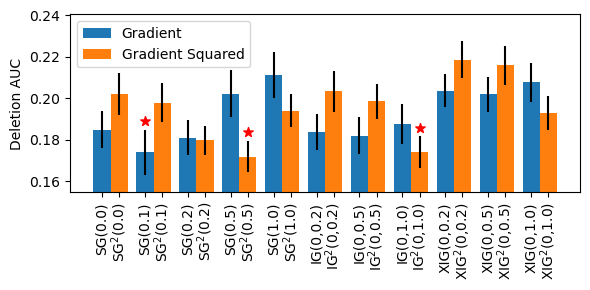

In [14]:
# barplot of the aucs
kind = "deletion"
condition = lambda x: (
    ("SL" not in x)
    and ("IG(0." not in x)
    and ("IG$^2$(0." not in x)
    and ("IG(1." not in x)
    and ("IG$^2$(1." not in x)
)
name = "dirac"
plot_aucs_side_by_side(aucs, ttests, kind, condition, name)
plt.show()

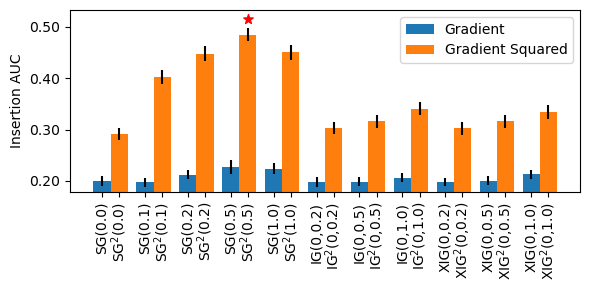

In [15]:
# barplot of the aucs
kind = "insertion"
name = "dirac"
plot_aucs_side_by_side(aucs, ttests, kind, condition, name)
plt.show()

In [ ]:
kind = "deletion"
condition = lambda x: "SL" in x
name = "SL"
plot_aucs_side_by_side(aucs, ttests, kind, condition, name)

In [ ]:
kind = "insertion"
condition = lambda x: "SL" in x
name = "SL"
plot_aucs_side_by_side(aucs, ttests, kind, condition, name)

In [ ]:
fig, axes = plt.subplots(
    1,
    1,
    figsize=(50, 7),
    sharey=True,
)
# increase the distance between the subplots
temp = aucs[("mean", "prediction")]
sns.heatmap(
    temp.T,
    annot=True,
    fmt=".3f",
    ax=axes,
    cmap="viridis",
)
# rotate labes

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
axes.set_xlabel("")
axes.set_ylabel("")


# highlight the significant differences
def add_patches(_ttests, ax):
    for i in range(_ttests.loc["prediction"].shape[0]):
        for j in range(_ttests.loc["prediction"].shape[1]):
            if _ttests.loc["prediction"].iloc[i, j] == 1:
                ax.add_patch(
                    plt.Rectangle(
                        (j, i), 1, 1, fill=False, edgecolor="red", linestyle="dashed"
                    )
                )
            elif _ttests.loc["prediction"].iloc[i, j] == 2:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="red"))


add_patches(ttests.T, ax=axes)
plt.savefig("outputs/figures/7_auc_heatmap.pdf", bbox_inches="tight")

# Deletion Insertion Curves

In [ ]:
def plot_accuracy_vs_q(
    selection,
    figsize=(7, 7),
    title="untitled",
    values=None,
    linestyle_fn=lambda x: None,
    marker_fn=lambda x: None,
    color_fn=lambda x: None,
):
    plt.figure(figsize=figsize)
    # draw vertical lines at ticks
    for q in merged_data_acc.q.unique():
        plt.axvline(q, linestyle=":", color="black", alpha=0.3, linewidth=1)
    # draw horizontal lines at ticks
    plt.ylim(0, 0.7)
    ticks = plt.yticks()[0]
    for acc in ticks:
        plt.axhline(
            acc,
            linestyle=":",
            color="black",
            alpha=0.3,
            linewidth=1,
        )

    for i, alpha in enumerate(selection):
        merged_data_acc_alpha = merged_data_acc[
            merged_data_acc.alpha_mask_value == alpha
        ]
        plt.plot(
            merged_data_acc_alpha.q,
            merged_data_acc_alpha.Accuracy,
            label=alpha + " " + f"{values[i]:.3f}" if values is not None else alpha,
            linestyle=linestyle_fn(alpha),
            marker=marker_fn(alpha),
            color=color_fn(alpha),
        )

    # location top right
    plt.legend(loc="upper right")
    plt.xlabel("% of pixels masked")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.savefig(f"outputs/figures/{title}.pdf", bbox_inches="tight")

# EX 7_4

In [25]:
save_metadata_dir = "outputs/metadata/7_0_ad*/"
metadata = load_experiment_metadata(save_metadata_dir, "merged_*.csv")

In [27]:
temp = metadata[
    (metadata.stream_statistic == "meanx")
    & (metadata.stream_name == "vanilla_grad_mask")
]
good_indices = [11,223]
for img_index in tqdm(good_indices):
    temp1 = temp[temp.image_index == img_index]
    img = temp1.iloc[0]
    temp4 = temp1[temp1.alpha_mask_value == 0.5].iloc[0]
    temp3 = temp1[temp1.alpha_mask_value == 0.2].iloc[0]
    temp2 = temp1[temp1.alpha_mask_value == 0.0].iloc[0]

    fig, axes = plt.subplots(1, 4, figsize=(15, 15 * 4))

    img = PIL.Image.open(img["image_path"])
    img = preprocess(img, 224).squeeze(0)
    axes[0].imshow(img, **imshow_args)
    old_data = None
    for i, temp0 in enumerate([temp4, temp3, temp2]):
        data = np.load(temp0["data_path"]).sum(axis=-1)
        if old_data is None:
            old_data = np.sign(data)
            print("old_data updated")

        data_mean = 0
        data_std = data.std()

        data = data * old_data
        axes[i + 1].imshow(
            data,
            cmap="bwr_r",
            vmin=data_mean - 3 * data_std,
            vmax=data_mean + 3 * data_std,
        )

    for ax in axes:
        ax.axis("off")
    save_axis(
        [
            f"original_{img_index}",
            f"sg_0.5_{img_index}",
            f"sg_0.2_{img_index}",
            f"sg_0.0_{img_index}",
        ],
        fig=fig,
        axes=axes,
        save_output_dir="outputs/figures/7_4",
        dpi=500,
    )
    plt.close(fig)

  0%|          | 0/2 [00:00<?, ?it/s]

old_data updated


 50%|█████     | 1/2 [00:02<00:02,  2.47s/it]

old_data updated


100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


In [ ]:
import tensorflow as tf


def save_figures_sg(image_index):
    image = PIL.Image.open(
        metadata[image_index == metadata["image_index"]].iloc[0]["image_path"]
    )
    image = tf.keras.utils.img_to_array(image)
    img_size = 224
    image = preprocess(image, img_size).squeeze(0)

    fig, axes = plt.subplots(1, 7, figsize=(28, 4))
    imshow_args = {
        # "cmap": "jet"
    }
    axes[0].imshow(image)
    axes[0].set_title("original")
    keys = metadata.alpha_mask_value.unique()
    for i, key in enumerate(keys):
        value = metadata[
            (metadata["alpha_mask_value"] == key)
            & (metadata["image_index"] == image_index)
        ]["data_path"]
        assert len(value) == 1, f"len(value)={len(value)}"
        value = value.iloc[0]
        data = np.load(value)
        max_ = data.max() * 0.5
        min_ = data.min() * 1.5
        axes[i + 1].imshow(
            data,
            vmin=min_,
            vmax=max_,
        )
        axes[i + 1].set_title(key)

    titles = []
    for ax in axes.flat:
        ax.label_outer()
        title = ax.title.get_text()
        ax.set_title("")
        title = f"{title}_{image_index}"
        titles.append(title)
        ax.set_xticks([])
        ax.set_yticks([])

    save_axis(
        titles,
        fig,
        axes,
        f"outputs/figures/7_4/",
        dpi=500,
    )
    plt.close(fig)


good_images = [5, 7, 86, 10, 53, 60, 82, 89]
for image_index in tqdm(good_images):
    save_figures_sg(image_index)

In [16]:
def save_figures(image_index):
    img_index_id = metadata.image_index == image_index
    image = PIL.Image.open(
        metadata[
            (metadata["alpha_mask_value"] == "ig_sg_u_x2_0_1.0") & img_index_id
        ].iloc[0]["image_path"]
    )
    img_size = 224
    image = preprocess(image, img_size).squeeze(0)
    al = np.load(
        metadata[
            (metadata["alpha_mask_value"] == "al_sg_u_x2_0_1.0") & img_index_id
        ].iloc[0]["data_path"]
    )
    igsg = np.load(
        metadata[
            (metadata["alpha_mask_value"] == "ig_sg_u_x2_0_1.0") & img_index_id
        ].iloc[0]["data_path"]
    )
    sg2 = np.load(
        metadata[
            (metadata["alpha_mask_value"] == "ig_sg_u_x2_0.5") & img_index_id
        ].iloc[0]["data_path"]
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    imshow_args = {
        # "cmap": "jet"
    }
    axes[0].imshow(image)
    axes[0].set_title("original")
    al_temp = 1 / (al + 1)
    al_mean = al_temp.mean()
    al_std = al_temp.std()
    im = axes[1].imshow(
        al_temp,
        vmin=al_mean - 2 * al_std,
        vmax=al_mean + 2 * al_std,
    )
    # two digits colorbar precision
    fig.colorbar(
        im,
        ax=axes[1],
        fraction=0.046,
        pad=0.04,
        format="%.2f",
    )
    axes[1].set_title("arglens")

    mean_igsg = igsg.mean()
    std_igsg = igsg.std()
    axes[2].imshow(
        igsg,
        vmin=0,
        vmax=mean_igsg + 3 * std_igsg,
    )
    axes[2].set_title("igsg")

    mean_sg = sg2.mean()
    std_sg = sg2.std()
    axes[3].imshow(
        sg2,
        vmin=0,
        vmax=mean_sg + 3 * std_sg,
    )
    axes[3].set_title("sg2")

    titles = []
    for ax in axes.flat:
        ax.label_outer()
        title = ax.title.get_text()
        ax.set_title("")
        title = f"{title}_{image_index}"
        titles.append(title)
        ax.set_xticks([])
        ax.set_yticks([])

    save_axis(
        titles,
        fig,
        axes,
        "outputs/figures/7_4/",
        dpi=500,
    )
    plt.close(fig)


good_images = metadata.image_index.unique()
for image_index in tqdm(good_images):
    save_figures(image_index)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:19<00:00,  2.50s/it]


In [16]:
target_mean, target_std = 0.162, 0.006
b_mean, b_std = 0.157, 0.007
pvalue = ttest(target_mean, target_std, 10, b_mean, b_std, 10).pvalue
significance = "significant" if pvalue < 0.05 else "not significant"
print(f"pvalue {pvalue:.3f} which is {significance}")

pvalue 0.104 which is not significant
